In [1]:
import pandas as pd
import numpy as np
import torch
import torch.utils.data as Data
import torch.nn as nn
from sklearn.metrics import mean_squared_error , mean_absolute_error #平均均方误差/平均绝对误差
import math
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
# 定义dataset
class my_Dataset(Data.Dataset):
    def __init__(self, features, labels):
        self.X = features
        self.y = labels

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.X.shape[0]

In [3]:
class WindDataset:
    def __init__(self,predict_step=3,label=5):
        standard_scaler = StandardScaler()
        raw_data = pd.read_excel("weather.xlsx")
        self.predict_step = predict_step
        self.label = label
        #标准化
        self.data = standard_scaler.fit_transform(raw_data)
        self.mean = standard_scaler.mean_[label]
        self.sd = math.sqrt(standard_scaler.var_[label])

    def denormalize(self, x):
        x = x*self.sd+self.mean
        return x

    def construct_set(self, train_por=0.65,val_por=0.2,test_por=0.15, window_size=50):
        train_x = []
        train_y = []
        val_x = []
        val_y = []
        test_x = []
        test_y = []
        len_train = int(self.data.shape[0] * train_por)
        #print("len_train",len_train)
        len_val = int(self.data.shape[0] * val_por)
        len_test = int(self.data.shape[0] * test_por)
        train_seqs = self.data[:len_train,:]
        print(train_seqs.shape)
        val_seqs = self.data[len_train:len_val+len_train,:]
        print(val_seqs.shape)
        test_seqs = self.data[len_train+len_val:len_val+len_train+len_test,:]
        print(test_seqs.shape)

        for i in range(train_seqs.shape[0] - window_size-self.predict_step+1):
            train_seq = train_seqs[i:i+window_size+self.predict_step]
            train_x.append(train_seq[0:window_size,:])
            train_y.append(train_seq[window_size:window_size+self.predict_step,self.label])

        for i in range(val_seqs.shape[0] - window_size-self.predict_step+1):
            val_seq = val_seqs[i:i+window_size+self.predict_step]
            val_x.append(val_seq[0:window_size,:])
            val_y.append(val_seq[window_size:window_size+self.predict_step,self.label])

        for i in range(test_seqs.shape[0] - window_size-self.predict_step+1):
            test_seq = test_seqs[i:i+window_size+self.predict_step]
            test_x.append(test_seq[0:window_size,:])
            test_y.append(test_seq[window_size:window_size+self.predict_step,self.label])

        train_set = my_Dataset(torch.Tensor(train_x), torch.Tensor(train_y).squeeze())
        val_set = my_Dataset(torch.Tensor(val_x), torch.Tensor(val_y).squeeze())
        test_set = my_Dataset(torch.Tensor(test_x), torch.Tensor(test_y).squeeze())
        return train_set, val_set, test_set

In [4]:
WindData = WindDataset()
train_set, val_set, test_set = WindData.construct_set()
batch_size = 16
train_loader = Data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
val_loader = Data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=True)
test_loader = Data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=True)

(347, 19)
(107, 19)
(80, 19)


/tmp/ipykernel_120155/3226413364.py:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  train_set = my_Dataset(torch.Tensor(train_x), torch.Tensor(train_y).squeeze())


In [5]:
#input_size – The number of expected features in the input x
# input  seq_len * batch_size*features 
class LSTMNet(nn.Module):
    def __init__(self,batch_size,input_size,hidden_size,output_size,num_layers,seq_len,device="cuda"):
        super().__init__()
        self.batch_size = batch_size
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.seq_len = seq_len
        self.lstm = nn.LSTM(input_size=input_size,hidden_size=hidden_size,num_layers=num_layers,batch_first=False)
        self.outlinear = nn.Sequential(
            nn.Linear(in_features=self.hidden_size,out_features=hidden_size//2),
            nn.LeakyReLU(),
            nn.Linear(in_features=hidden_size//2,out_features=self.output_size)
        )
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)        
    def forward(self,x):
        h,c = (torch.zeros(self.num_layers,self.seq_len,self.hidden_size).to(x.device) for _ in range(2))
        H,(h,c) = self.lstm(x,(h,c))
        #print(H.shape)
        out = H[:,-1,:].squeeze()
        out = self.outlinear(out)
        return out

In [6]:
device = torch.device("cuda")
input_size = train_set.X.shape[-1]
hidden_size = 256#8的倍数
output_size = 3
lr = 0.0001
epochs=80
num_layers = 3
seq_len = 50
loss = nn.MSELoss()
lstm = LSTMNet(batch_size,input_size,hidden_size,output_size,num_layers,seq_len).to(device)
optimizer = torch.optim.Adam(lstm.parameters(), lr)

In [7]:
#mean_absolute_percentage_error 平均绝对百分比误差
def mean_absolute_percentage_error(y, pred):
    mask = y != 0
    y = y[mask]
    pred = pred[mask]
    mape = np.abs((y - pred) / y)
    mape = np.mean(mape) * 100
    return mape


def eval(y, pred):
    y = y.cpu().numpy()
    pred = pred.cpu().numpy()
    mse = mean_squared_error(y, pred)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(y, pred)
    mape = mean_absolute_percentage_error(y, pred)
    return [rmse, mae, mape]

In [8]:
def evaluate(net,data_iter, loss, denormalize_fn, device='cuda:0'):
    rmse, mae, mape = 0, 0, 0
    batch_count = 0
    total_loss = 0.0
    net.eval()
    for X, y in data_iter:
        X = X.to(device)
        y = y.to(device)
        y_hat = net(X)
        l = loss(y_hat, y.long())
        y = denormalize_fn(y)
        y_hat = denormalize_fn(y_hat)
        a, b, c = eval(y.detach(), y_hat.detach())
        rmse += a
        mae += b
        mape += c
        total_loss += l.detach().cpu().numpy().tolist()
        batch_count += 1
    return [rmse / batch_count, mae / batch_count, mape / batch_count], total_loss / batch_count

In [9]:
def train(net, train_iter, val_iter, test_iter, loss_fn, denormalize_fn, optimizer, num_epoch,device='cuda:0'):
    train_loss_lst = []
    val_loss_lst = []
    train_score_lst = []
    val_score_lst = []
    epoch_time = []
    for epoch in range(num_epoch):
        net.train()
        epoch_loss = 0
        batch_count = 0
        batch_time = []
        rmse, mae, mape = 0, 0, 0
        for X, Y in train_iter:
            #print("X:",X.shape)
            #print("Y:",Y.shape)
            batch_s = time.time()
            X = X.to(device).float()
            Y = Y.to(device).float()
            optimizer.zero_grad()
            y_hat = net(X)
            #print("y_hat",y_hat.shape)
            #print("y_hat:",y_hat)
            #print("Y:",Y)
            loss = loss_fn(y_hat, Y)
            loss.backward()
            optimizer.step()

            Y = denormalize_fn(Y)
            #print("Y:",Y)
            y_hat = denormalize_fn(y_hat)
            #print("y_hat:",y_hat)
            a, b, c = eval(Y.detach(), y_hat.detach())
            rmse += a
            mae += b
            mape += c
            epoch_loss += loss.detach().cpu().numpy().tolist()
            batch_count += 1

            batch_time.append(time.time() - batch_s)

        train_loss = epoch_loss / batch_count
        train_loss_lst.append(train_loss)
        train_score_lst.append([rmse/batch_count, mae/batch_count, mape/batch_count])

        # 验证集
        val_score, val_loss = evaluate(net, val_iter, loss_fn, denormalize_fn, device)
        val_score_lst.append(val_score)
        val_loss_lst.append(val_loss)

        epoch_time.append(np.array(batch_time).sum())
        print('*** epoch%d, train loss %.8f, train rmse %.4f, val loss %.8f, val rmse %.6f, time use %.3fs' %(epoch + 1, train_loss, train_score_lst[-1][0], val_loss, val_score[0], epoch_time[-1]))

    # 输出最终训练结果
    print(f'\n{"*" * 40}\nFinal result:')
    print(f'Total time {np.array(epoch_time).sum():.2f}s')

    # 计算测试集效果
    test_score, test_loss = evaluate(net,test_iter, loss_fn, denormalize_fn, device)
    print('Test result:')
    print(f'Test RMSE: {test_score[0]}    Test MAE: {test_score[1]}    Test MAPE: {test_score[2]}')
    return train_loss_lst, val_loss_lst, train_score_lst, val_score_lst

In [10]:
def visualization(train_loss,val_loss):
    x1=np.linspace(0,len(train_loss),len(train_loss))
    plt.plot(x1,train_loss,label='train_loss',linewidth=1.5)
    plt.plot(x1,val_loss,label='test_loss',linewidth=1.5)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

def plot_metric(score_log):
    score_log = np.array(score_log)

    plt.figure(figsize=(10, 6), dpi=300)
    plt.subplot(2, 2, 1)
    plt.plot(score_log[:, 0], c='#d28ad4')
    plt.ylabel('RMSE')

    plt.subplot(2, 2, 2)
    plt.plot(score_log[:, 1], c='#e765eb')
    plt.ylabel('MAE')

    plt.subplot(2, 2, 3)
    plt.plot(score_log[:, 2], c='#6b016d')
    plt.ylabel('MAPE')

    plt.show() 

In [11]:
train_loss_lst, val_loss_lst, train_score_lst, val_score_lst = train(lstm, train_loader, val_loader, test_loader,loss, WindData.denormalize, optimizer,epochs,device=device)

*** epoch1, train loss 1.21329143, train rmse 3.1758, val loss 0.28694396, val rmse 2.201172, time use 0.175s
*** epoch2, train loss 1.19639514, train rmse 3.1716, val loss 0.28765876, val rmse 2.215734, time use 0.145s
*** epoch3, train loss 1.18167920, train rmse 3.1113, val loss 0.28545851, val rmse 2.216161, time use 0.148s
*** epoch4, train loss 1.14605665, train rmse 3.0906, val loss 0.25169451, val rmse 2.087204, time use 0.151s
*** epoch5, train loss 1.08911314, train rmse 2.9985, val loss 0.22220347, val rmse 1.956696, time use 0.162s
*** epoch6, train loss 1.00246707, train rmse 2.8641, val loss 0.20072190, val rmse 1.823223, time use 0.140s
*** epoch7, train loss 0.89460544, train rmse 2.7179, val loss 0.18355335, val rmse 1.680215, time use 0.144s
*** epoch8, train loss 0.57710032, train rmse 2.1563, val loss 0.17675489, val rmse 1.486022, time use 0.138s
*** epoch9, train loss 0.40054778, train rmse 1.8347, val loss 0.17470834, val rmse 1.450353, time use 0.136s
*** epoch1

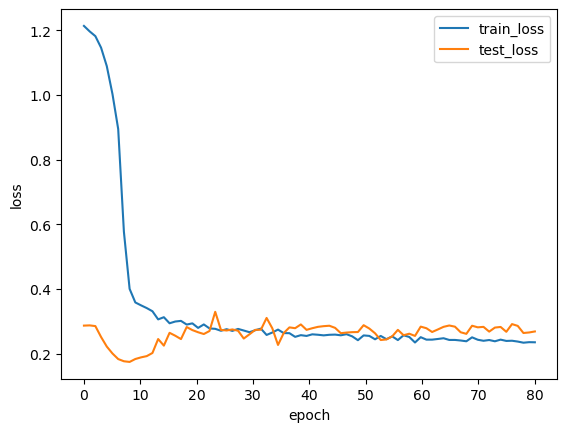

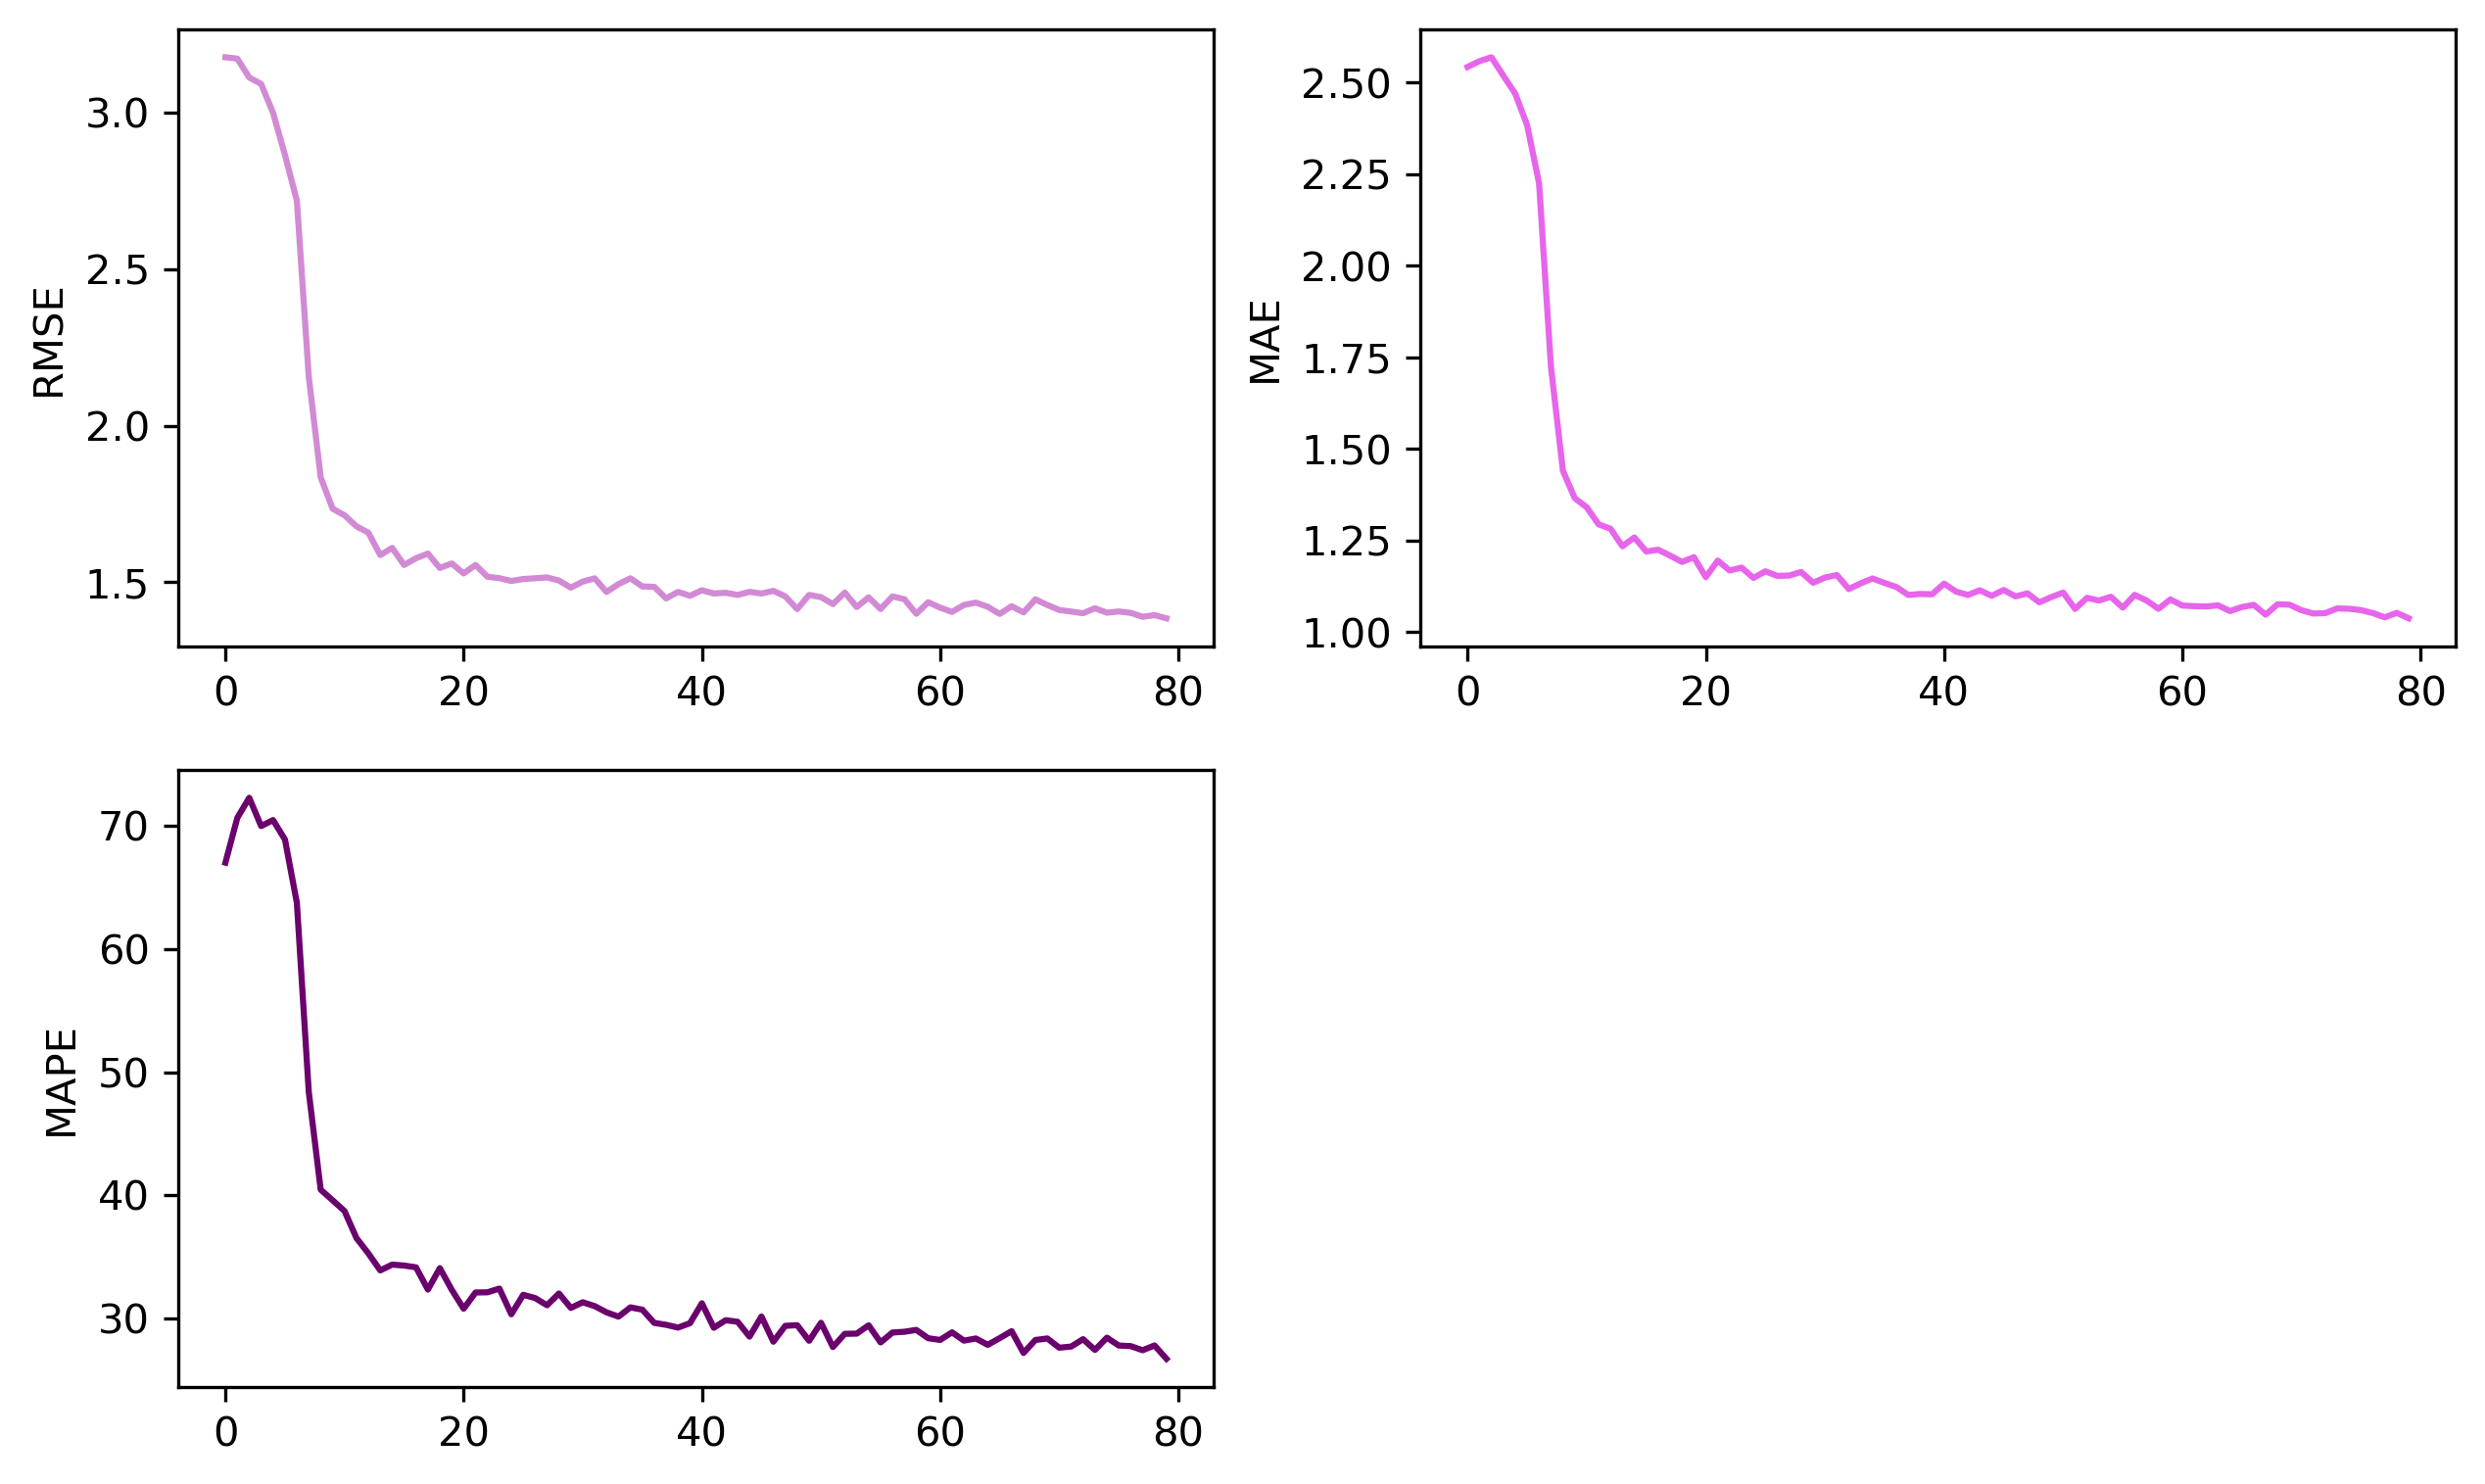

In [12]:
#RMSE和样本有关，RMSE大表示预测值和理论值的差值也大
visualization(train_loss_lst, val_loss_lst)
plot_metric(train_score_lst)

In [13]:
train_loader = Data.DataLoader(train_set, batch_size=1, shuffle=True, num_workers=4, drop_last=True)
val_loader = Data.DataLoader(val_set, batch_size=1, shuffle=False, num_workers=4, drop_last=True)
test_loader = Data.DataLoader(test_set, batch_size=1, shuffle=False, num_workers=4, drop_last=True)

y_predict: (295, 3)
y_true: (295, 3)
x1: (295,)


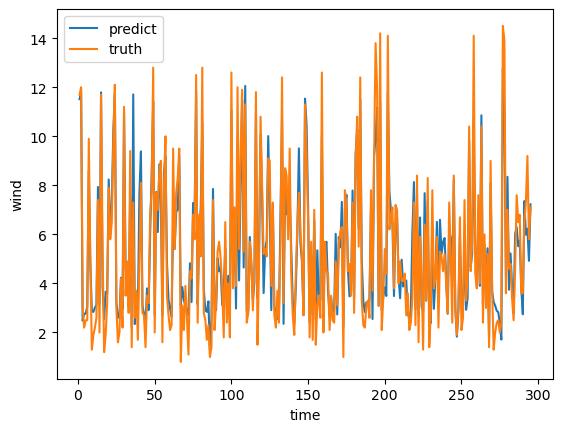

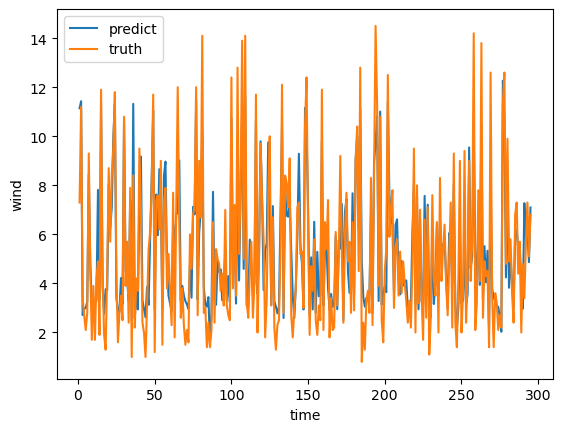

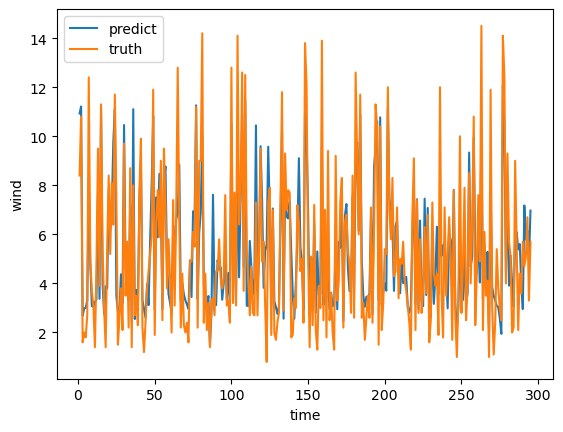

In [14]:
def time_series_visualize(net,test_iter,denormalize_fn,num_epoch):
    net.eval()
    y_predict = []
    y_true = []
    for epoch in range(num_epoch):
        for x,y in test_iter:
            y_hat = denormalize_fn(net(x.to(device)).detach().cpu()).numpy()
            y = denormalize_fn(y)
            y_true.append(y.detach().numpy())
            y_predict.append(y_hat)
    y_predict = np.array(y_predict).squeeze()# epoch batch feature 28X3
    print("y_predict:",y_predict.shape)
    y_true = np.array(y_true).squeeze() # 28X3
    print("y_true:",y_true.shape)
    x1 = np.linspace(1,y_predict.shape[0],y_predict.shape[0])
    print("x1:",x1.shape)
    for j in range(y_predict.shape[-1]):    
        plt.plot(x1,y_predict[:,j],label='predict')
        plt.plot(x1,y_true[:,j],label='truth')
        plt.xlabel("time")
        plt.ylabel("wind")
        plt.legend()
        plt.show()
time_series_visualize(lstm,train_loader,WindData.denormalize,1)

y_predict: (55, 3)
y_true: (55, 3)
x1: (55,)


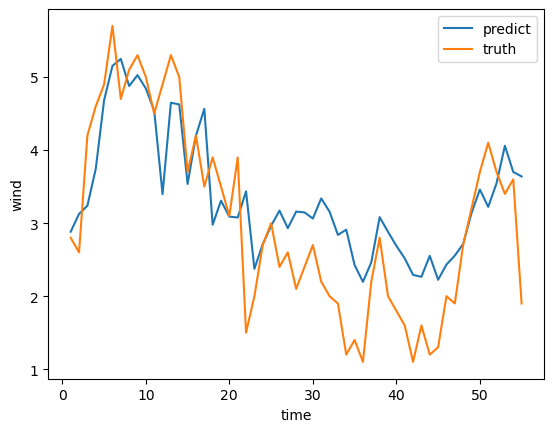

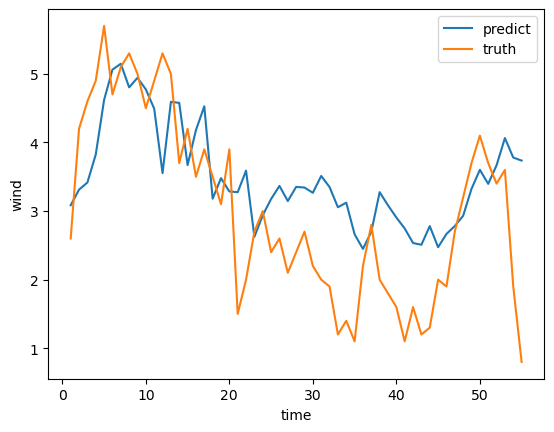

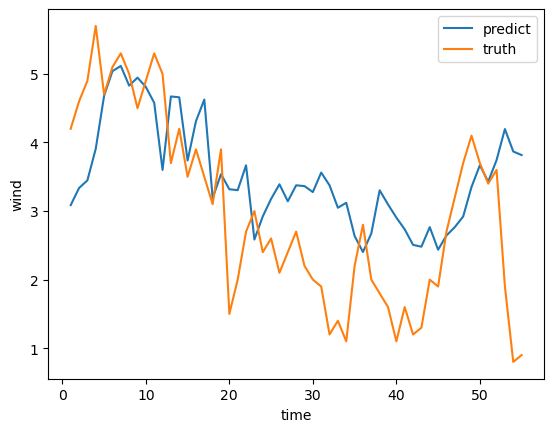

In [15]:
time_series_visualize(lstm,val_loader,WindData.denormalize,1)

y_predict: (28, 3)
y_true: (28, 3)
x1: (28,)


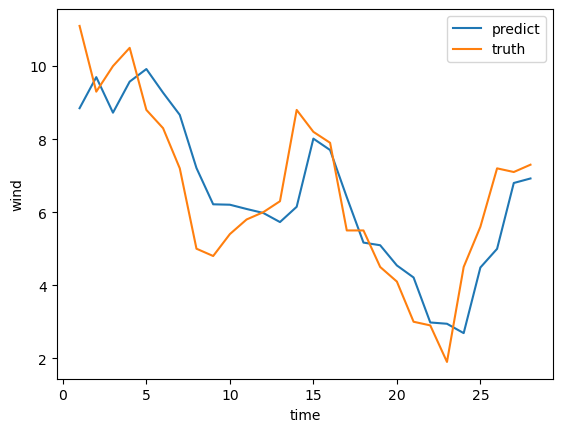

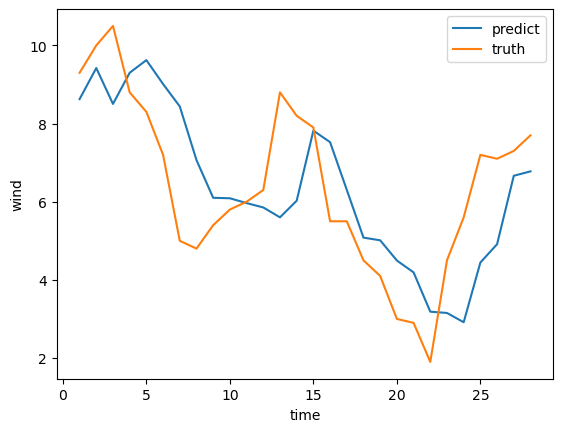

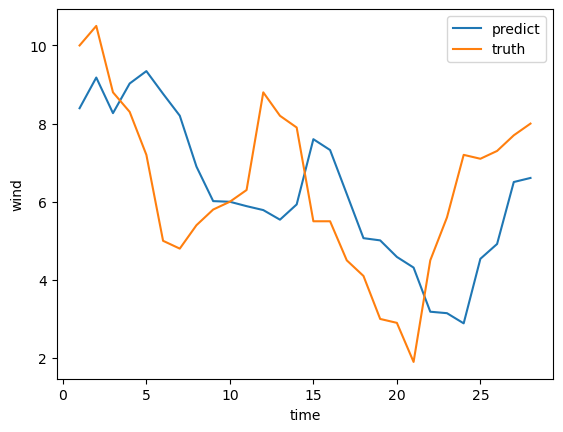

In [16]:
time_series_visualize(lstm,test_loader,WindData.denormalize,1)